https://github.com/rolling-scopes-school/ml-intro/tree/2021/2_linear_regression  
https://github.com/palinkapro/RS_School/blob/main/2_Linear_regression/palinkapro_rs_ml_lr2.ipynb  

In [21]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy.optimize import least_squares
from sklearn.utils.estimator_checks import check_estimator
pd.set_option('display.max_columns', None)

In [22]:
data = pd.read_csv('data.csv', index_col='ID').drop('Unnamed: 0', axis=1)

In [179]:
# data.columns
# data.dtypes
# data.info()
# data.describe()
# data.hist(figsize=(20,20));
# data.boxplot(column=['Age','Height']);
# data['Height'].plot.box(figsize=(3,3));

In [23]:
print(f"Total number of players in dataset {data.shape[0]}")

Total number of players in dataset 18207


In [24]:
top = 10
print(tabulate(
    sorted(list(zip(data.columns, data.isnull().sum(), data.isnull().sum() / data.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name       null_cnt    null_perc
-----------  ----------  -----------
Loaned From       16943      93.0576
LS                 2085      11.4516
ST                 2085      11.4516
RS                 2085      11.4516
LW                 2085      11.4516
LF                 2085      11.4516
CF                 2085      11.4516
RF                 2085      11.4516
RW                 2085      11.4516
LAM                2085      11.4516


In [25]:
print(f"Weight column type is '{data['Weight'].dtype}'")

Weight column type is 'object'


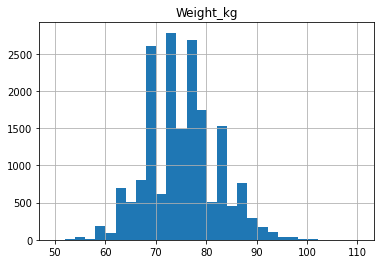

In [26]:
data['Weight_float'] = data['Weight'].str.extract(r'([0-9]+)lbs').astype(float)
data['Weight_float'].fillna(data['Weight_float'].median())
data['Weight_kg'] = data.apply(lambda row: row['Weight_float'] * 0.454, axis=1)
data.hist(column='Weight_kg', bins=30);

**Task 1** (1 point). Built a histogram of the height distribution in meters from footbal player data. Remember that height is in format feet 'inches. Instead of filling null values with some constant just drop them. Use .dropna for specified column.

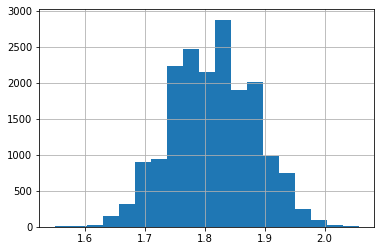

In [27]:
data[['Height_ft', 'Height_inch']] = data['Height'].str.split("'", 1, expand=True).astype(float)
data['Height_m'] = (data['Height_ft'] * 12 + data['Height_inch']) * 0.0254
data['Height_m'].dropna().hist(bins=19);

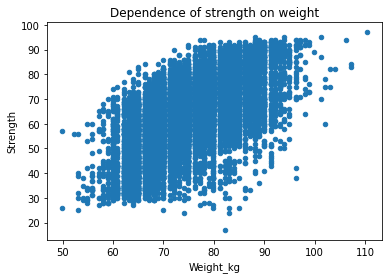

In [28]:
data.plot.scatter(x='Weight_kg', y='Strength')
plt.title('Dependence of strength on weight');

In [415]:
data['Value'] = data['Value'].apply(extract_money)

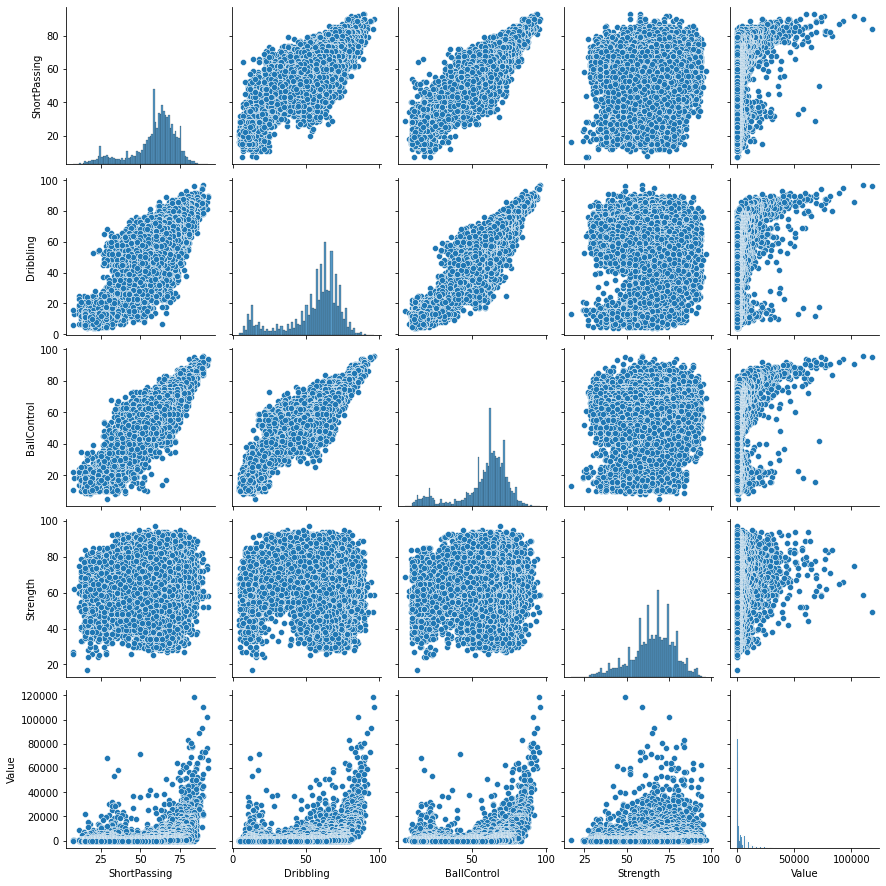

In [416]:
sns.pairplot(data[['ShortPassing', 'Dribbling', 'BallControl', 'Strength','Value']]);

In [31]:
data['age_group'] = data.apply(lambda x: 'young' if x['Age'] < 20 else 'mature' if x['Age'] <= 30 else 'masters', axis=1)
distr = data.groupby('age_group').count().max(axis=1)[['young', 'mature', 'masters']]

In [206]:
# data.groupby('age_group').size()

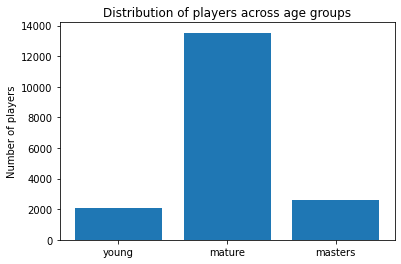

In [32]:
plt.bar(distr.index, distr.values)
plt.ylabel('Number of players')
plt.title('Distribution of players across age groups');

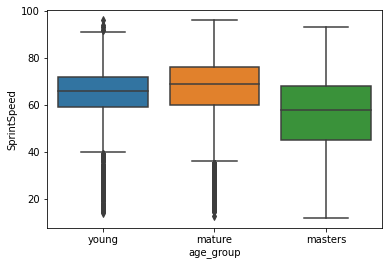

In [33]:
sns.boxplot(x='age_group', y='SprintSpeed', data=data, order=['young', 'mature', 'masters']);

In [34]:
data.fillna({'BallControl': data['BallControl'].mean(), 'Dribbling': data['Dribbling'].mean()}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data['Dribbling'].values, data['BallControl'].values, train_size=0.8)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [35]:
lr = Ridge(alpha=0)
lr.fit(X=X_train, y=y_train)
print(f'w_0 = {lr.intercept_}, w_1 = {lr.coef_[0]}')

w_0 = 12.553800836080853, w_1 = 0.8275379520600981


In [36]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [37]:
data['predicted_BallControl'] = lr.predict(data['Dribbling'].values.reshape(-1, 1))
data[['Name', 'Dribbling', 'BallControl', 'predicted_BallControl']].head()

,Name,Dribbling,BallControl,predicted_BallControl
ID,,,,
158023,L. Messi,97.0,96.0,92.824982
20801,Cristiano Ronaldo,88.0,94.0,85.377141
190871,Neymar Jr,96.0,95.0,91.997444
193080,De Gea,18.0,42.0,27.449484
192985,K. De Bruyne,86.0,91.0,83.722065


**Task 2** (0.5 point). Write your own function for MSE calculation using the formula above. Calculate train and test MSE, compare to built-in method (sklearn.metrics.mean_squared_error)

In [38]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()
    # return (1 / len(y_true)) * np.sum(np.square(y_true - y_pred))

In [39]:
mean_squared_error(y_train, y_pred_train), mse(y_train, y_pred_train)

(32.736412471140234, 32.736412471140234)

In [40]:
mean_squared_error(y_test, y_pred_test), mse(y_test, y_pred_test)

(33.43303012109472, 33.43303012109472)

In [41]:
assert round(mean_squared_error(y_train, y_pred_train), 9) == round(mse(y_train, y_pred_train), 9)
assert round(mean_squared_error(y_test, y_pred_test), 9) == round(mse(y_test, y_pred_test), 9)

**Task 3** (1.5 points). Visualize the dependence of test BallControl predictions and real BallControl score on Dribbling score. Don't forget to add axis and plot names!

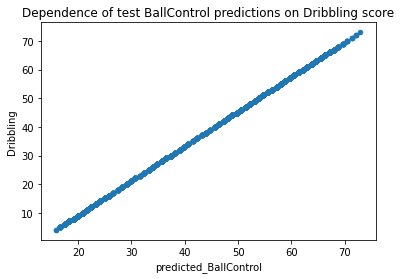

In [42]:
data[len(X_train):].plot.scatter(x='predicted_BallControl', y='Dribbling')
plt.title('Dependence of test BallControl predictions on Dribbling score');

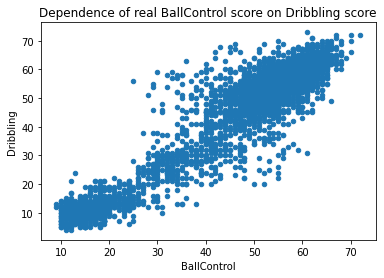

In [43]:
data[len(X_train):].plot.scatter(x='BallControl', y='Dribbling')
plt.title('Dependence of real BallControl score on Dribbling score');

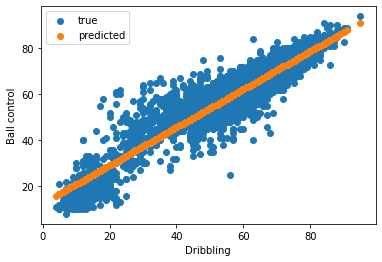

In [44]:
fig, axes = plt.subplots()
axes.scatter(X_test, y_test, label='true')
axes.scatter(X_test, y_pred_test, label='predicted')
plt.xlabel('Dribbling')
plt.ylabel('Ball control')
plt.legend();

**Task 4 (5 points).** Implement your own Linear Regression class for any number of input features and settable boolean parameter *fit_intercept*. 

In this task you will work with _optimize_ module of [_scipy_](https://docs.scipy.org/doc/scipy/reference/) open-source library for mathematics, science, and engineering. You will need a function [_least_squares_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) that finds a coefficients for linear regression by minimizing the sum of the squares of the residuals (which is equivalent to MSE minimizing). More information about least squares approach [here](https://en.wikipedia.org/wiki/Least_squares). <br><br>
Even though this function has many parameters, you need only a few of them to complete the task (the rest will be filled in with default values automatically).
- **fun** computes a vector of residuals given weights, features and target, we provide you a function template _compute_residuals_
- **x0** this is an initial weights vector. You can either pass a vector of zeros[n_features] or fill in randomly.
- **args** are fixed arguments to _fun_ function (which we are not going to optimize). In that particular case you will need to pass X and y.

You can access optimized weights by accessing the field **.x** of object which returns by this function.  

!!! IMPORTANT  
Please complete this assignment **without any cycles**. You may use the standard operations of matrix \ vector multiplication ans different statistic calculation with NumPy. Otherwise, your solution may not go through asserts.

In [45]:
def compute_residuals(w, X, y): return (X @ w.T - y)

In [46]:
class LinearRegression(BaseEstimator):
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.n_features_in_ = X.shape[1]
        X_train = X.astype('float64')
        y_train = y.astype('float64')
        
        if self.fit_intercept:
            X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
        
        w0 = np.zeros(X_train.shape[1])
        fun = lambda w: compute_residuals(w, X_train, y_train)
        res = least_squares(fun, w0)
        
        if self.fit_intercept:
            self.coef_ = res.x[:-1]
            self.intercept_ = res.x[-1]
        
        else:
            self.coef_ = res.x
            self.intercept_ = 0
        
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return X.dot(self.coef_) + self.intercept_

In [47]:
lr = LinearRegression()
ridge = Ridge(alpha=0)
lr_no_intercept = LinearRegression(fit_intercept=False)
ridge_no_intercept = Ridge(alpha=0, fit_intercept=False)
check_estimator(lr)
check_estimator(lr_no_intercept)
data.fillna({'BallControl': data['BallControl'].mean()
             , 'Dribbling': data['Dribbling'].mean()
             , 'Strength': data['Strength'].mean()}, inplace=True)
X_sample, y_sample = data[['Dribbling', 'Strength']], data['BallControl']
lr.fit(X_sample, y_sample)
ridge.fit(X_sample, y_sample)
assert np.allclose(lr.predict(X_sample), ridge.predict(X_sample), rtol=1e-03), "Your model with intercept not accurate enough!"
lr_no_intercept.fit(X_sample, y_sample)
ridge_no_intercept.fit(X_sample, y_sample)
assert np.allclose(lr_no_intercept.predict(X_sample), ridge_no_intercept.predict(X_sample), rtol=1e-03), "Your model without intercept not accurate enough!"

In [48]:
features = ['BallControl', 'ShortPassing', 'Strength', 'Weight_float', 'Weight_kg']
target = 'Dribbling'
for feat in features:
    data.fillna({feat: data[feat].mean()}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data[target].values, train_size=0.8, random_state=2)

In [49]:
lr = Ridge(0)
lr.fit(X=X_train, y=y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print(f'Train MSE {mean_squared_error(y_train, y_pred_train)}, test MSE {mean_squared_error(y_test, y_pred_test)}')

Train MSE 37.67559002416093, test MSE 33.955657131727506


In [50]:
print(f'w_0 = {lr.intercept_}, w_1, w_2, w_3, w_4, w_5 = {lr.coef_}')

w_0 = 11.854965767427267, w_1, w_2, w_3, w_4, w_5 = [ 1.09358190e+00 -4.75391140e-02 -1.27364951e-01  1.03731541e+08
 -2.28483570e+08]


In [51]:
player = data[features + [target]].iloc[0:2]
player['Predicted_dribbling'] = lr.predict(player[features].values)
player.head()

,BallControl,ShortPassing,Strength,Weight_float,Weight_kg,Dribbling,Predicted_dribbling
ID,,,,,,,
158023,96.0,90.0,59.0,159.0,72.186,97.0,96.208253
20801,94.0,81.0,79.0,183.0,83.082,88.0,90.567673


In [52]:
player['Weight_kg'] = player['Weight_kg'] + [-0.001, 0.001]
player['Predicted_dribbling_with_error'] = lr.predict(player[features].values)
player.head()

,BallControl,ShortPassing,Strength,Weight_float,Weight_kg,Dribbling,Predicted_dribbling,Predicted_dribbling_with_error
ID,,,,,,,,
158023,96.0,90.0,59.0,159.0,72.185,97.0,96.208253,228579.778296
20801,94.0,81.0,79.0,183.0,83.083,88.0,90.567673,-228393.002372


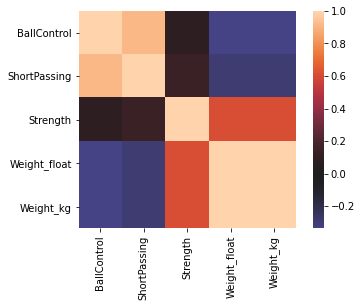

In [53]:
sns.heatmap(data[features].corr(method='pearson'), center=0, square=True);

In [54]:
features = ['BallControl', 'ShortPassing', 'Strength', 'Weight_kg']
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data[target].values, train_size=0.8, random_state=2)
lr = Ridge(alpha=0)
lr.fit(X=X_train, y=y_train)
player['Predicted_dribbling_with_error'] = lr.predict(player[features].values)
player.head()

,BallControl,ShortPassing,Strength,Weight_float,Weight_kg,Dribbling,Predicted_dribbling,Predicted_dribbling_with_error
ID,,,,,,,,
158023,96.0,90.0,59.0,159.0,72.185,97.0,96.208253,96.208130
20801,94.0,81.0,79.0,183.0,83.083,88.0,90.567673,90.567307


**Task 5 (up to 5 points).** Build a Linear Regression model for _Value_ prediction for every football player and validate it. You **have to** use either your custom Linear Regression class or `sklearn.linear_model.Ridge` with regularization param alpha=0. Steps you need to follow:
- Extract float number from _Value_ field in DataFrame (**0.5 points**)
- Сhoose more features that you expect to influence on player _Value_ (at least 10)
- Plot feature correlation matrix. (**0.5 points**)
- Drop features that are highly correlated with each other (_abs_(corr) > 0.9) one by one until no correlated pairs left. _Hint_: you may reuse code from Task_9 in HW_1 for automatic correlated pairs selection. (**1.5 points**)
- Split data into train/test with some proportion (**0.5 points**)
- Train a model on train dataset, make predictions both for train and test. (**0.5 points**)
- Measure the model quality in terms of MSE in train and test samples,  (**0.5 points**)
- Write a short report about the work done. Why did you take these particular features? Can you find a logical explanation for high correlation of some of your features? Are you satisfied with the quality of predictions? etc. (**1 point**)  

**Penalties**  
- **-1 point** if used a different model besides custom Linear Regression or `sklearn.linear_model.Ridge` with regularization param alpha=0
- **-0.5 points** if number of selected features BEFORE removal of linearly dependent ones is less than 10.
- **-0.5 points** if did not remove linearly dependent features before training the model. 

Acceleration  SprintSpeed    0.921933
ShotPower     LongShots      0.889266
BallControl   LongShots      0.836065
dtype: float64
Train MSE 7.058932779626499, test MSE 7.591848148505749


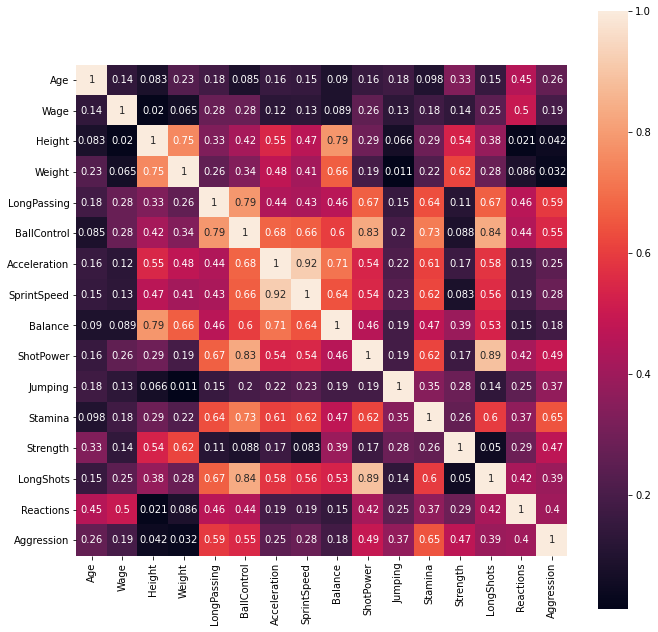

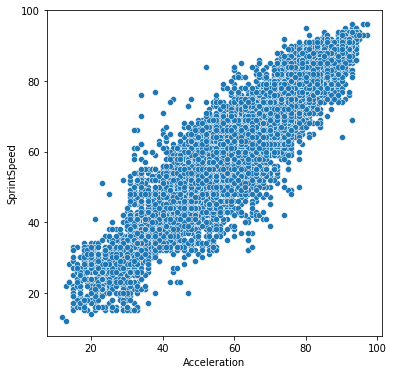

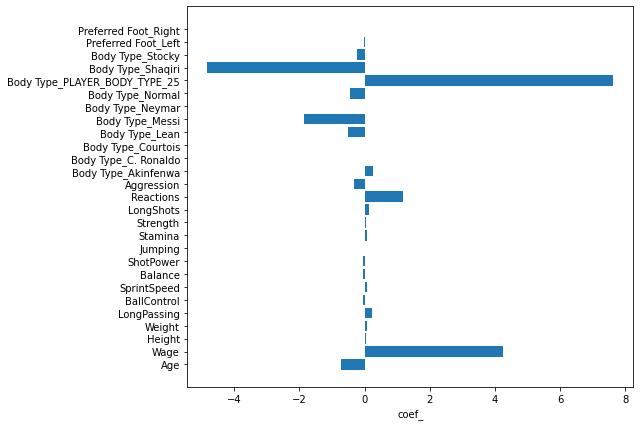

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Value'

cat_features = [
    'Body Type',
    'Preferred Foot'
]

num_features = [
    'Age',
    'Wage',
    'Height',
    'Weight',
    'LongPassing',
    'BallControl',
    'Acceleration',
    'SprintSpeed',
    'Balance',
    'ShotPower',
    'Jumping',
    'Stamina',
    'Strength',
    'LongShots',
    'Reactions',
    'Aggression'
]

def extract_weight(s):
    return float(s[:-3]) * 0.454

def extract_height(s):
    a = s.split("'")
    if len(a) == 1: a.append(0)
    return (int(a[0]) * 12 + int(a[1])) * 0.0254

def extract_money(s):
    a, b, l = s[1:-1], s[1:], s[-1]
    res = float(a) * {'M':1e6,'K':1e3}[l] if l in ['M','K'] else float(b)
    return res / 1e6

data = pd.read_csv('data.csv', index_col='ID')
X, y = data[num_features + cat_features].copy(), data[target].copy()

X.loc[:,'Weight'] = X['Weight'].dropna().apply(extract_weight)
X.loc[:,'Height'] = X['Height'].dropna().apply(extract_height)
X.loc[:,'Wage'] = X['Wage'].dropna().apply(extract_money)
y = y.apply(extract_money)

X.loc[:,cat_features] = X[cat_features].fillna(X[cat_features].mode().iloc[0])
X.loc[:,num_features] = X[num_features].fillna(X[num_features].median())

X = pd.get_dummies(X, columns=cat_features)

X_num = X[num_features]
corr = X_num.corr(method ='pearson').abs()
np.fill_diagonal(corr.values, np.nan)
corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
print(corr[:3]) # corr[corr > 0.9]

plt.figure(figsize=(11, 11))
sns.heatmap(X_num.corr(method='pearson').abs(), annot=True, square=True);

plt.figure(figsize=(6, 6))
sns.scatterplot(x='Acceleration', y='SprintSpeed', data=X);

num_features.remove('Acceleration')
X.drop('Acceleration', axis=1, inplace=True)

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8, random_state=2)
X_train[:, :len(num_features)] = scaler.fit_transform(X_train[:, :len(num_features)])
X_test[:, :len(num_features)] = scaler.transform(X_test[:, :len(num_features)])

lr = Ridge(alpha=1) # 0
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print(f'Train MSE {mean_squared_error(y_train, y_pred_train)}, test MSE {mean_squared_error(y_test, y_pred_test)}')

plt.figure(figsize=(8,7))
plt.barh(X.columns.values, lr.coef_)
plt.xlabel('coef_');

In [39]:
# df = pd.DataFrame({'param': X.columns.values, 'value': lr.coef_, 'abs': np.abs(lr.coef_)})
# display(df.sort_values(by='abs', ascending=False))
# print(f'intercept_: {lr.intercept_}')
# print(f'coef_: {lr.coef_}')
# plt.scatter(X_train['Wage'].values, y_train)
# plt.scatter(X_train['Wage'].values, y_pred_train)
# plt.scatter(X_test['Wage'].values, y_test)
# plt.scatter(X_test['Wage'].values, y_pred_test)
# plt.xlabel('Acceleration')
# plt.ylabel('SprintSpeed')
# plt.scatter(X['Acceleration'], X['SprintSpeed']);